#Automated Detection of Kidney Cysts, Stones, and Tumors in CT Radiography using Pytorch Framework and CT Images


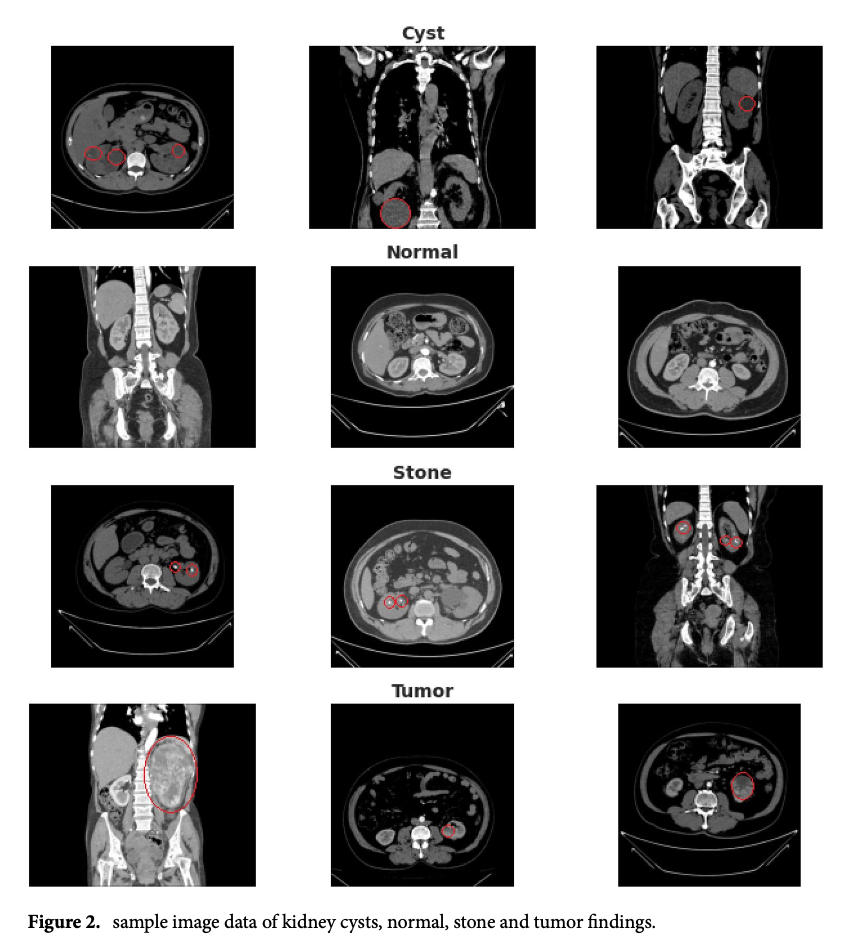


# Kidney Tumor Detection Project

## Introduction

In this project, I will be building machine learning models to detect kidney tumors from CT scan images. Kidney cancer is one of the 10 most common cancers, affecting around 400,000 people globally each year. Early detection greatly improves survival rates, but manual diagnosis is tedious and time-consuming.

The goal of this project is to develop an automatic kidney tumor detection system that can help radiologists analyze CT scans faster and more accurately. I will be using PyTorch to build and train convolutional neural network models on a dataset of kidney CT scan slices.

The key outputs of this project will be:

- A labeled kidney CT dataset for model training and testing
- Data preprocessing and augmentation code
- Trained deep learning models for kidney tumor detection
- Model evaluation code and results
- Visualizations of model activations and detections

This work will build on recent research in using deep learning for medical imaging analysis. In particular, I will be referencing the following papers that have achieved strong results on related kidney tumor detection tasks:

- Paper 1 on kidney tumor classification
- Paper 2 on transfer learning for kidney tumor detection
- Paper 3 on combining CNNs and segmentation for detection

By the end of this notebook, I hope to have an accurate kidney tumor detection model that can generalize well to new CT scan data. The final model and code could be integrated into a decision support system to aid radiologists in analyzing kidney scans.


### About Dataset
Context
CT KIDNEY DATASET: Normal-Cyst-Tumor and Stone

Content
The dataset was collected from PACS (Picture archiving and communication system) from different hospitals in Dhaka, Bangladesh where patients were already diagnosed with having a kidney tumor, cyst, normal or stone findings. Both the Coronal and Axial cuts were selected from both contrast and non-contrast studies with protocol for the whole abdomen and urogram. The Dicom study was then carefully selected, one diagnosis at a time, and from those we created a batch of Dicom images of the region of interest for each radiological finding. Following that, we excluded each patient's information and meta data from the Dicom images and converted the Dicom images to a lossless jpg image format. After the conversion, each image finding was again verified by a radiologist and a medical technologist to reconfirm the correctness of the data.

Our created dataset contains 12,446 unique data within it in which the cyst contains 3,709, normal 5,077, stone 1,377, and tumor 2,283

You can access the dataset: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

#Vision Transformers and deep Learning approach for kidney detection (Paper)

Based on the paper, here is a summary of the models and transformers used, along with an overview of the paper's implementation:

Models and Transformers Used:

- CNN-based deep learning models using transfer learning:
    - VGG16
    - ResNet50
    - Inception v3
- Vision Transformer variants:
    - EANet (External Attention Transformer)
    - CCT (Compact Convolutional Transformer)
    - Swin Transformer (Shifted Window Transformer)

The paper implemented these 6 models in total on a kidney CT image dataset to detect kidney abnormalities - cysts, stones, tumors.

Summary and Implementation:

- Collected and annotated a dataset of 12,446 CT abdomen images, with kidney cyst, stone, tumor and normal cases.
- Conducted exploratory analysis showing similar color distributions across classes.  
- Applied data augmentation and normalization pre-processing techniques.
- Implemented transfer learning by fine-tuning final layers of VGG16, ResNet50 and Inception v3.
- Built EANet, CCT and Swin transformer models for comparison using TensorFlow Addons and custom changes.
- Evaluated models on accuracy, AUC-ROC, precision, recall, F1 scores using 80-20 and 10-fold validation.
- Visualized model attention using GradCAM to explain predictions and compare model behaviors.  

The Swin transformer performed the best with 99.3% accuracy, highest recall, precision and F1 scores.  VGG16 watched most discriminative image regions. The paper shows promise for using both CNNs and vision transformers for detecting kidney abnormalities from CT scans.

The models and implementation provide a strong baseline for additional research and product development in this application area.

In [76]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will install the following library to split our dataset on folder

In [77]:
!pip install split-folders==0.4.3

Let's get started by importing some necessary libraries.

In [78]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision import models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import splitfolders



# Data Preprocessing

We will download the dataset directly to the google drive from kaggle using the code below

In [ ]:
# Set path to the directory containing your Kaggle API token
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/MyKaggle-token/"

# Change directory to where you want to download the dataset
os.chdir("/content/drive/MyDrive/MachineLearningProjects/Dataset")

# Download the dataset using the correct dataset name
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

# Unzip the downloaded dataset (if it's a zip file)
!unzip -q ct-kidney-dataset-normal-cyst-tumor-and-stone.zip


100% 1.51G/1.52G [00:26<00:00, 59.9MB/s]
100% 1.52G/1.52G [00:26<00:00, 62.5MB/s]


Now, it is time to split the dataset folders into  training, testing and validation folders

In [ ]:
# dataset path
input_folder = '/content/drive/MyDrive/MachineLearningProjects/Dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

#output folder path
output_folder = '/content/drive/MyDrive/MachineLearningProjects/Kidney-splitted-dataset'

# Splitting the dataset into training (80%), validation (10%), and test (10%) sets
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 12446 files [45:46,  4.53 files/s]



Let's look into the data folder.

In [79]:
data_dir = '/content/drive/MyDrive/MachineLearningProjects/Kidney-splitted-dataset'
print(os.listdir(data_dir))

['train', 'val', 'test']


So, we have two directories called "train" and "test" containing the training and the testing images for the model. Let's check how many output classes it contains.

In [80]:
classes = os.listdir(data_dir + "/train")
print(classes)

['Cyst', 'Normal', 'Stone', 'Tumor']


We have 4 output classes referring to four weather conditions. Now, let's see how many images we have in the training set, test set and in each output class for training and test.

In [81]:
# training imageset
count = 0
dirc = 0
print("Train Image directory:\n")
for root, dirs, files in os.walk(data_dir + '/train'):


    # Calculating and displaying the number of images in each class
    if files:
        file_count = len(files)
        print("'{}' : {}".format(classes[dirc], file_count))
        dirc += 1


    # Total number of train images
    count += len(files)


train_len = count
print("\nTrain Set:", train_len)  # Training images


Train Image directory:

'Cyst' : 2967
'Normal' : 4061
'Stone' : 1101
'Tumor' : 1826

Train Set: 9955


In [82]:
# test imageset
count = 0
dirc = 0
print("Test Image Directory:\n")
for root, dirs, files in os.walk(data_dir + '/test'):


    # Calculating and displaying the number of images in each class
    if files:
        file_count = len(files)
        print("'{}' : {}".format(classes[dirc], file_count))
        dirc += 1


    # Total number of testing images
    count += len(files)


test_len = count
print("\nTest Set:", test_len)  # Test images


Test Image Directory:

'Cyst' : 372
'Normal' : 509
'Stone' : 139
'Tumor' : 229

Test Set: 1249


In [83]:
# Total image size
print("We  have total: ", train_len + test_len, "images")

We  have total:  11204 images


**Note:** We can see the image distribution in the training set is odd but even for the test set.

###Let's check the shape and size of some of our images.

In [84]:
# We can use the ImageFolder class from torchvision to load the data as PyTorch tensors
img_size = ImageFolder(data_dir, tt.ToTensor())
len(img_size)

12446

In [85]:
# Shape of few images in our dataset
img,_ = img_size[53]
print(img.shape)
img,_ = img_size[404]
print(img.shape)
img,_ = img_size[775]
print(img.shape)
img,_ = img_size[1058]
print(img.shape)
img,_ = img_size[1120]
print(img.shape)

torch.Size([3, 646, 798])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 1029, 1271])


As you can see,  we have different image shapes across the training and test sets.
So, we need to resize all our images to prevent any complications or problems later.
Let's start by finding the minimum and maximum height and width of our images.

In [ ]:
height = []
width = []
for image,_ in img_size:
  height.append(image.shape[1])
  width.append(image.shape[2])
print("minimum height: {}\nmaximum height: {}\nminimum width: {}\nmaximum width: {}".format(min(height), max(height), min(width), max(width)))

### Data transforms (normalization & data augmentation)


We will apply the following changes to our image :
*   *Resizing* our images to `94px x 94px`.
*   *Test set as our validation set* to make our model more familiar with the data and enhance its performance.
*   *Channel-wise data normalization* by subtracting the mean and dividing by the standard deviation across each channel to bring the pixels in the range of `-1 to 1` to prevent values of one channel from disproportionately affecting the losses and gradients while training.
*   *Randomized data augmentations* to make our model generalize better by flipping,padding, and so on.




In [87]:
# statistics for normalization
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
stats = (mean, std)

# Resize images to 94px x 94px
image_size = (224, 224)


# Use the test set as our validation set for better performance
valid_transforms = tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(mean=mean, std=std)
])


# Normalize the data channel-wise to range from -1 to 1
normalize_transforms = tt.Normalize(mean=mean, std=std)



# Apply randomized data augmentations for better generalization
train_transforms = tt.Compose([
    tt.Resize(image_size),
    # tt.ToPILImage(),
    tt.RandomCrop(image_size, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    normalize_transforms
])


In [88]:
# our train and validation dataset
train_ds = ImageFolder(data_dir+'/train', train_transforms)
valid_ds = ImageFolder(data_dir+'/test', valid_transforms)

In [89]:
# Shape of few images in our dataset
img,_ = train_ds[50]
print(img.shape)
img,_ = train_ds[400]
print(img.shape)
img,_ = train_ds[750]
print(img.shape)
img,_ = valid_ds[30]
print(img.shape)
img,_ = valid_ds[70]
print(img.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


Hence, we can see all the images in our datasets are resized to the same size. Since the data consists of 94x94 px color images with 3 channels (RGB), each image tensor has the shape (3, 94, 94).

we will see some of our normalized images in the code below:

In [90]:
def show_example(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

**img.permute(1, 2, 0)** - rearranges the dimensions of the image tensor to match the expected format for **plt.imshow()**, which is (**height, width, channels**). The **permute()** function is used to transpose the dimensions of the tensor, converting it from the PyTorch tensor format (**channels, height, width**) to the expected format.

**img.permute(1, 2, 0)** indicates that the original second dimension of the tensor becomes the first dimension of the transposed tensor, the original third dimension becomes the second dimension, and the original first dimension becomes the third dimension. This ensures that the image tensor is in the format expected by plt.imshow().

Finally, **plt.imshow()** displays the image on the screen using the transposed tensor.

Label:  Cyst (0)


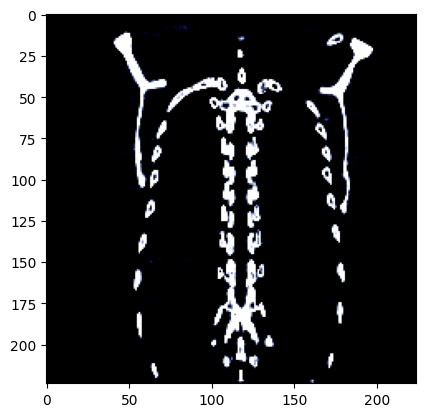

In [91]:
show_example(*train_ds[45])

Label:  Cyst (0)


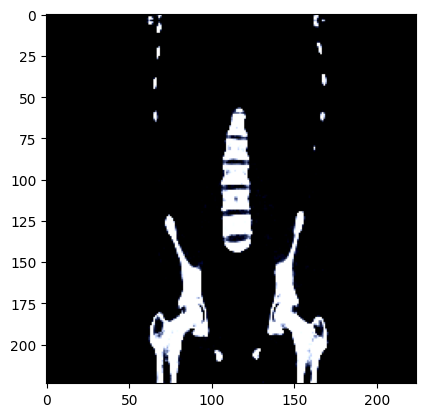

In [92]:
show_example(*train_ds[355])

Label:  Cyst (0)


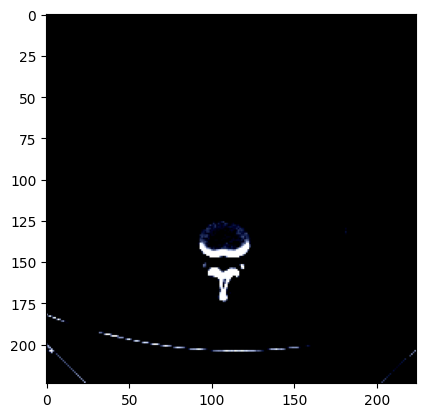

In [93]:
show_example(*valid_ds[93])

###How do we choose batch_size?

Choosing the batch size involves considering **memory constraints**, **computational efficiency**, **dataset size**, and **generalization**. It is a trade-off between training time and model performance. Smaller batch sizes introduce more *randomness and can prevent overfitting*, while larger batch sizes leverage *parallel processing for faster training*. The ideal batch size varies depending on the specific task and hardware, typically ranging from
 32-128 samples. Experimentation is necessary to find the optimal balance.

Next, we can create data loaders for retrieving images in batches. We'll use a batch size of 64.

In [94]:
batch_size = 64


Next, we create data loaders and make **num_workers=2**, which specifies the number of worker processes to use for data loading. Using multiple workers can speed up data loading by loading multiple batches in parallel.


Then, we make **pin_memory=True**, which enables pinned memory, which allows faster data transfer between CPU and GPU memory when using a GPU. This can improve training speed if you are using a GPU.

In [95]:
# data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to denormalize the pixels values in order to bring them back into the range (0,1).

In [96]:
# function to denormalize image
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means


# function to see batches
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

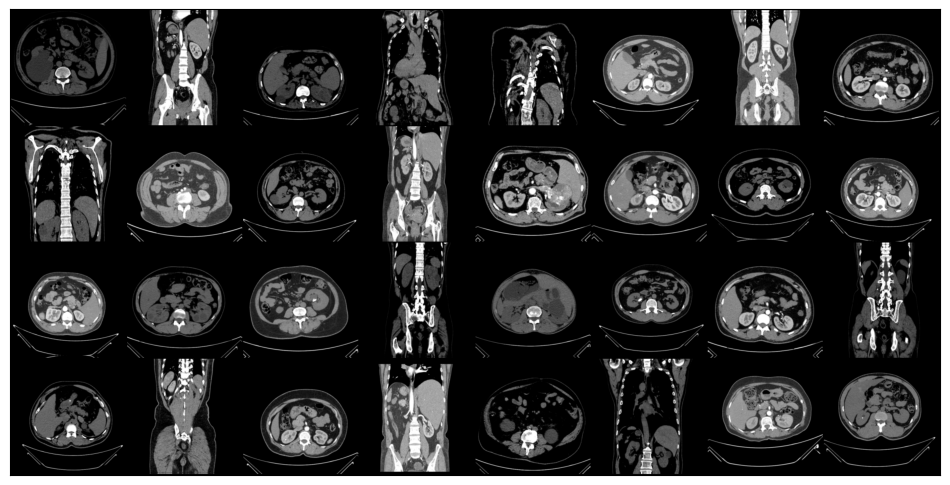

In [97]:
show_batch(train_dl)

## Using a CUDA (GPU)

GPU boasts of superior parallel computation power than CPU and is highly used when doing classificaton problems to train models faster. To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [98]:
# to check that we are using CPU or GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


In [99]:
# DeviceDataLoader class to move our model & data to the GPU as required
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [100]:
# Let's check whether we are using a CPU or GPU
device = get_default_device()
device

device(type='cuda')

 Now, GPU is enabled and so we can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU.

In [101]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### We will use **ResNet9**, which is a CNN architecture

We will be implementing a Convolutional Neural Network (CNN) architecture called ResNet9. This architecture includes a special building block called the residual block, which combines the original input with the output of one or more convolutional layers.

By incorporating the residual block, we can achieve significant improvements in the model's performance. Additionally, after each convolutional layer, we will include a batch normalization layer, which helps normalize the outputs of the previous layer.

ResNet9 consists of a total of 8 convolutional layers, 8 Rectified Linear Unit (ReLU) layers for introducing non-linearity, 3 MaxPool layers for downsampling, 1 Flatten layer to convert the output into a 1-dimensional vector, and 1 Dropout layer for regularization. This architecture is effective in mitigating issues such as **overfitting**, which can occur when a model becomes too specialized to the training data.

In summary, ResNet9 is a CNN architecture that leverages the power of residual blocks and batch normalization to enhance model performance. It includes several convolutional and ReLU layers, along with pooling, flattening, and dropout layers, which collectively contribute to better generalization and can help prevent overfitting.

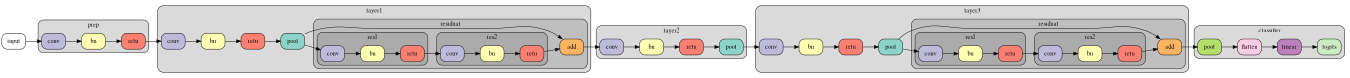

For this project, we are going to test both resnet9 and resnet 50 models

In [102]:
# function to calculate the accuracy
def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    accuracy = torch.sum(preds == labels).item() / len(preds)
    return torch.tensor(accuracy)


# class for image classification part of our project
class ImageClassificationBase(nn.Module):

  # function for training images
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images) # Get predicted output
        loss = F.cross_entropy(outputs, labels) # Calculate loss
        return loss



    # function to calculate the validation loss and accuracy
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels) # Calculate loss
        acc = accuracy(outputs, labels) # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        # Calculate average validation loss
        val_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.mean(torch.stack(val_losses))


        # Calculate average validation accuracy
        val_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.mean(torch.stack(val_accs))

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        last_lr = result['lrs'][-1]
        train_loss = result['train_loss']
        val_loss = result['val_loss']
        val_acc = result['val_acc']


        # epoch summary
        print(f"Epoch [{epoch}], last_lr: {last_lr:.5f}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")


###Resnet50 model

In [103]:
# Subclass ImageClassificationBase to create ResNet50 model
class ResNet50(ImageClassificationBase):
    def __init__(self, num_classes=4):
        super().__init__()
        # Load the pre-trained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)

        # Freeze all layers in ResNet
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer to match the number of output classes
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Creating an instance of ResNet50 model
model = ResNet50(num_classes=4)


In [104]:
# # a convolutional block
# def conv_block(in_channels, out_channels, pool=False):
#     layers = [
#         nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#         nn.BatchNorm2d(out_channels),
#         nn.ReLU(inplace=True)
#     ]
#     if pool:
#         layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)


# # The ResNet9 model
# class ResNet9(ImageClassificationBase):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()

#         # The layers for feature extraction
#         self.conv1 = conv_block(in_channels, 64)
#         self.conv2 = conv_block(64, 128, pool=True)
#         self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
#         self.conv3 = conv_block(128, 256, pool=True)
#         self.conv4 = conv_block(256, 512, pool=True)
#         self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

#         # The classifier layers
#         self.classifier = nn.Sequential(
#             nn.MaxPool2d(11),
#             nn.Flatten(),
#             nn.Dropout(0.2),
#             nn.Linear(512, num_classes)
#         )


# # function to make forward in backpropogation
#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)
#         out = self.res1(out) + out
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.res2(out) + out
#         out = self.classifier(out)
#         return out


In [105]:
# changing our device(cpu to gpu if cuda available)
model = to_device(model, device)
model

ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

# Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

* **Learning rate scheduling:** Instead of using a fixed learning rate, we will use a
learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the *One Cycle Learning Rate Policy*, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

* **Weight decay:** We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

* **Gradient clipping:** Apart from the layer weights and outputs, it is also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

Let's define a fit_one_cycle function to incorporate these changes. We'll also record the learning rate used for each batch.

In [106]:
@torch.no_grad()

#  Evaluates the model on the validation set.
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


#  Retrieves the current learning rate from the optimizer.
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']



# Trains the model using the one-cycle learning rate policy
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step() # to update
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [107]:
# record the learning rate , validation accuracy and validation loss
history = evaluate(model,valid_dl)
history

{'val_loss': 1.3584399223327637, 'val_acc': 0.3695312440395355}

We're now ready to train our model. We'll be using the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training.

In [108]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [109]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                        grad_clip=grad_clip,
                        weight_decay=weight_decay,
                        opt_func=opt_func)


Epoch [0], last_lr: 0.00151, train_loss: 0.8429, val_loss: 0.6267, val_acc: 0.7860
Epoch [1], last_lr: 0.00435, train_loss: 0.5091, val_loss: 0.5475, val_acc: 0.8049
Epoch [2], last_lr: 0.00759, train_loss: 0.5225, val_loss: 0.4176, val_acc: 0.8426
Epoch [3], last_lr: 0.00971, train_loss: 0.4603, val_loss: 0.3537, val_acc: 0.8807
Epoch [4], last_lr: 0.00994, train_loss: 0.3977, val_loss: 0.3949, val_acc: 0.8677
Epoch [5], last_lr: 0.00950, train_loss: 0.4216, val_loss: 0.2323, val_acc: 0.9150
Epoch [6], last_lr: 0.00867, train_loss: 0.3629, val_loss: 0.2356, val_acc: 0.9177
Epoch [7], last_lr: 0.00750, train_loss: 0.3256, val_loss: 0.2026, val_acc: 0.9283
Epoch [8], last_lr: 0.00611, train_loss: 0.2902, val_loss: 0.2955, val_acc: 0.9040
Epoch [9], last_lr: 0.00463, train_loss: 0.2408, val_loss: 0.1753, val_acc: 0.9383
Epoch [10], last_lr: 0.00317, train_loss: 0.2008, val_loss: 0.1597, val_acc: 0.9391
Epoch [11], last_lr: 0.00188, train_loss: 0.1618, val_loss: 0.1734, val_acc: 0.9344
Ep

Our model trained to over 95% accuracy after 15 epochs in under 24 minutes 2 s!

Let's plot the valdation set accuracies to study how the model improves over time.

In [123]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

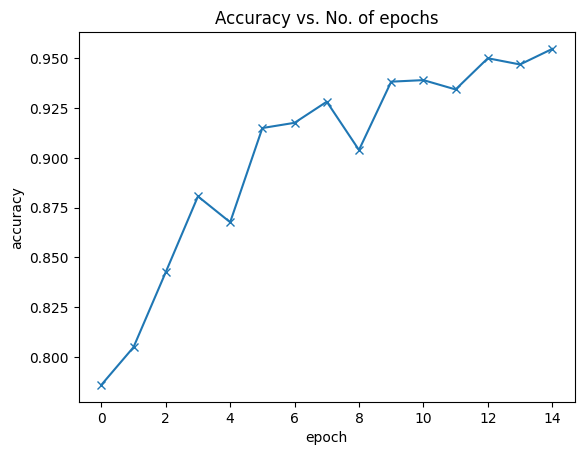

In [124]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [125]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

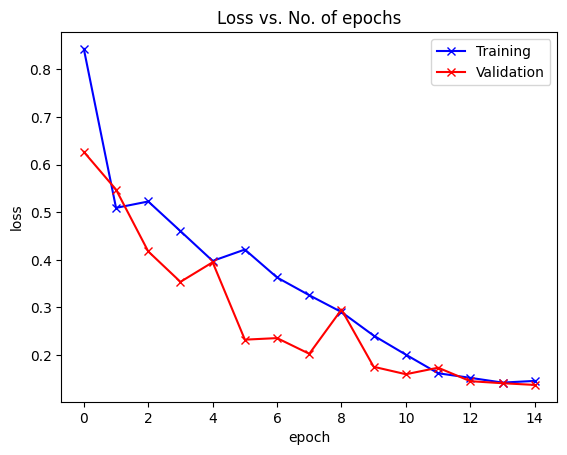

In [126]:
plot_losses(history)

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [127]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

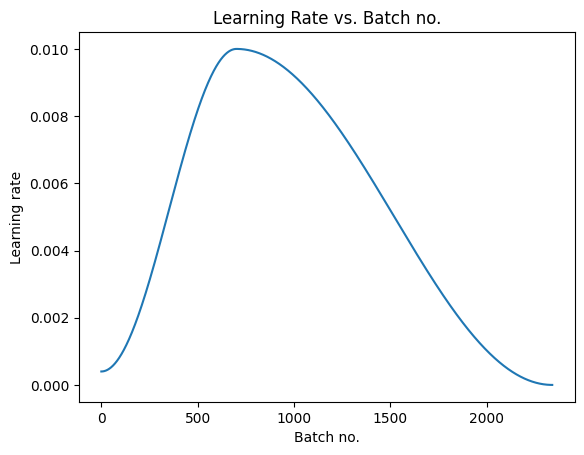

In [128]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.

# Testing with individual images

Now it's time to test out our model with some images from the predefined test dataset of 100 images.

In [129]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Cyst , Predicted: Stone


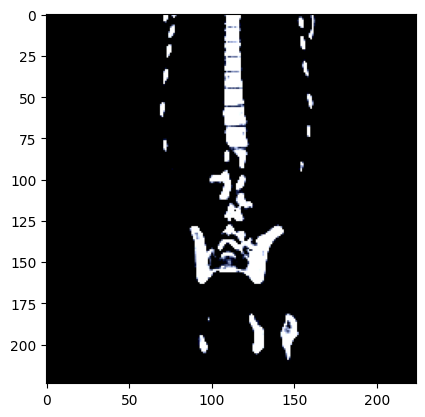

In [130]:
img, label = valid_ds[4]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Cyst , Predicted: Cyst


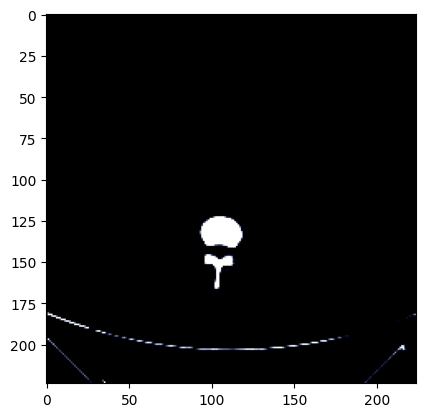

In [131]:
img, label = valid_ds[42]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Cyst , Predicted: Cyst


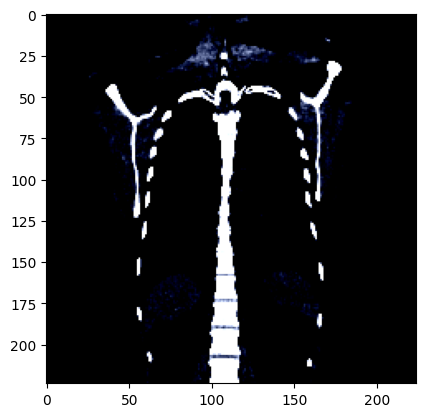

In [132]:
img, label = valid_ds[64]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Cyst , Predicted: Cyst


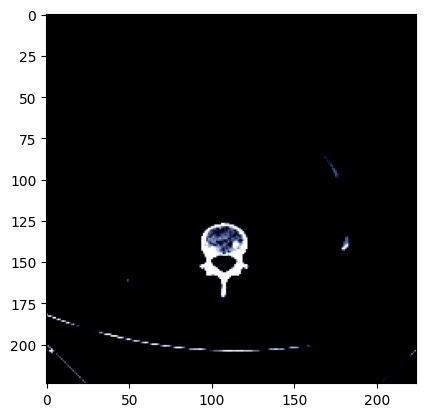

In [133]:
img, label = valid_ds[90]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Cyst , Predicted: Cyst


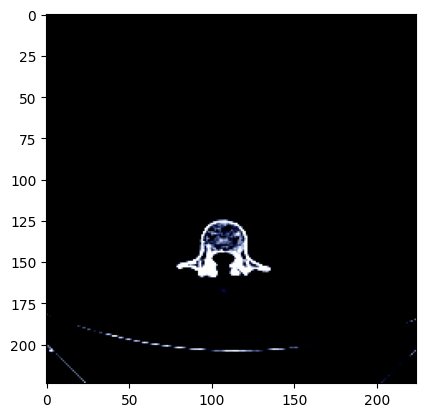

In [134]:
img, label = valid_ds[97]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

## Saving our model part

Now, we save the weights of the model

In [135]:
torch.save(model.state_dict(), '/content/KidneyDiseaseAutomation-resnet50.pth')

Download the saved model from google colab

In [137]:
from google.colab import files
files.download('/content/KidneyDiseaseAutomation-resnet50.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion

Finally, we achieve an accuracy of over 92% with the ResNet9 model for weather image classification. The success of our model can be attributed to the implementation of various advanced techniques, including normalization, data augmentation, regularization, and residual connections. These techniques have effectively improved the model's generalization capabilities and prevented overfitting. By training the model from scratch and documenting our lines of code with great comments, we have achieved to detect weather by using the single image.